In [2]:
# In a Jupyter Notebook: preparation/eda_and_cleaning.ipynb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os

# Load validated data (assuming latest partition)
churn_df = pd.read_csv(r"C:\Users\mrakkuma\OneDrive - Magna\BITS\Sem2\DMML\Assignment\Assignment\customer_churn_pipeline\data\bronze\source=telco_csv\year=2025\month=08\day=23\telco_churn_20250823.csv")

# Load interaction data from SQLite
conn = sqlite3.connect(r"C:\Users\mrakkuma\OneDrive - Magna\BITS\Sem2\DMML\Assignment\Assignment\customer_churn_pipeline\data\silver\interactions.db")
interactions_df = pd.read_sql_query("SELECT * FROM customer_interactions", conn)
conn.close()

# Merge datasets
df = pd.merge(churn_df, interactions_df, on='customerID', how='left')

# --- Data Cleaning ---

# 1. Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0.0, inplace=True)

# 2. Correct data types
df = df.replace({1: 'Yes', 0: 'No'})

# 3. Fill NaNs for interaction data (for customers not found in the source)
df['support_calls'].fillna(0, inplace=True)
df['satisfaction_score'].fillna(3, inplace=True) # Assume neutral satisfaction
df['last_interaction_days_ago'].fillna(999, inplace=True) # Assume very long time

print("Data loaded and cleaned. Shape:", df.shape)
df.head()


Data loaded and cleaned. Shape: (7043, 24)


C:\Users\mrakkuma\AppData\Local\Temp\ipykernel_48384\2371893257.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0.0, inplace=True)
C:\Users\mrakkuma\AppData\Local\Temp\ipykernel_48384\2371893257.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,support_calls,satisfaction_score,last_interaction_days_ago
0,7590-VHVEG,Female,No,Yes,No,Yes,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,3,Yes,15
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.5,No,2,5,21
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes,3,87
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,2,3,88
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,4,3,22


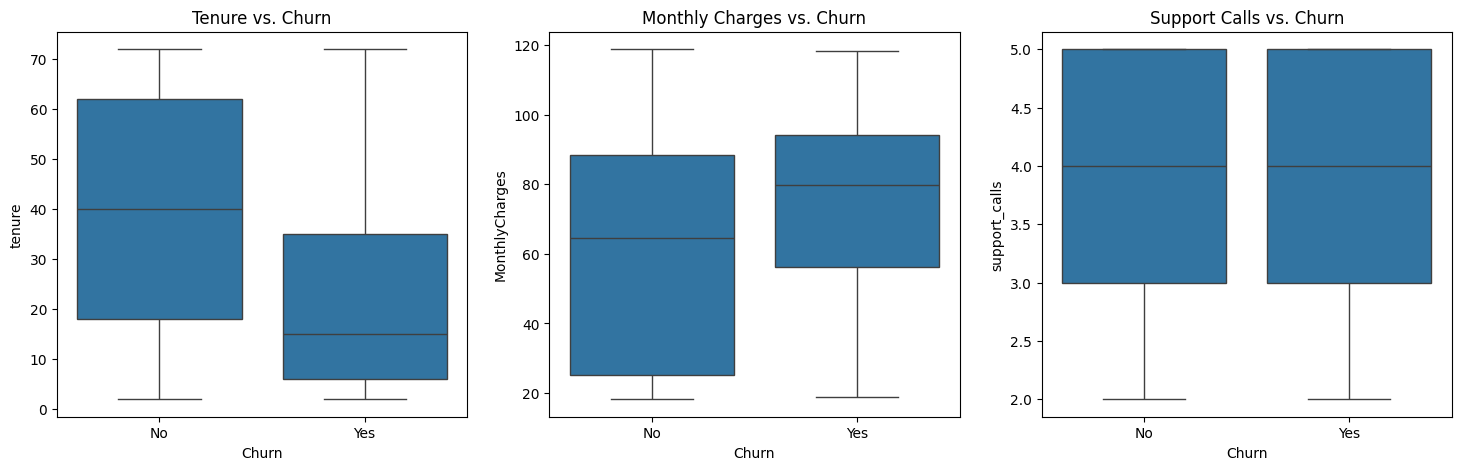

In [3]:
# Ensure numeric types for plotting
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['support_calls'] = pd.to_numeric(df['support_calls'], errors='coerce')

# Box plots for numerical features vs. Churn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0]).set_title('Tenure vs. Churn')
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1]).set_title('Monthly Charges vs. Churn')
sns.boxplot(x='Churn', y='support_calls', data=df, ax=axes[2]).set_title('Support Calls vs. Churn')
plt.show()


These box plots immediately yield powerful hypotheses:
Customers who churn have a significantly lower median tenure.
Customers who churn have a higher median monthly charge, suggesting price sensitivity. 27
Customers who churn tend to make more support calls, indicating dissatisfaction with the service. 16


2. Bivariate Analysis: Categorical Features vs. Churn



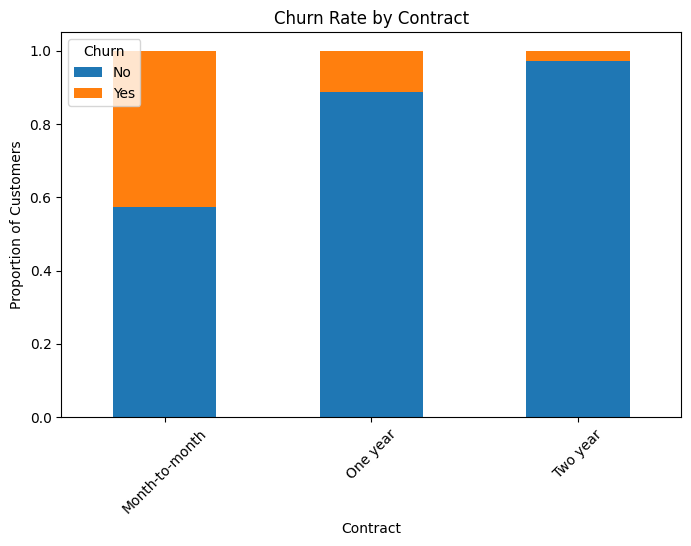

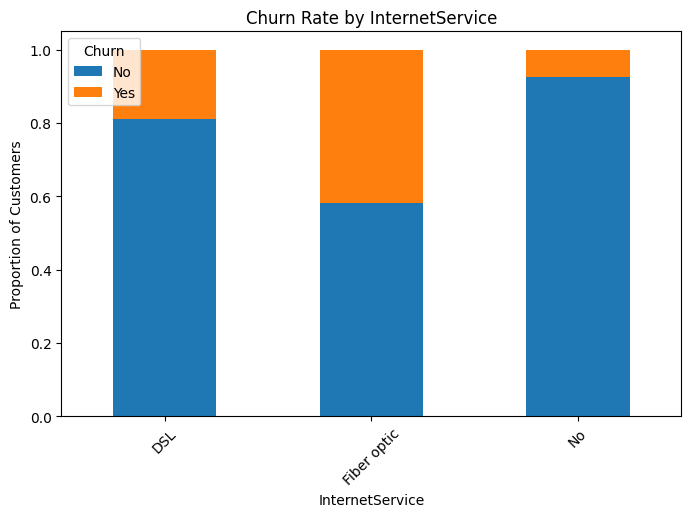

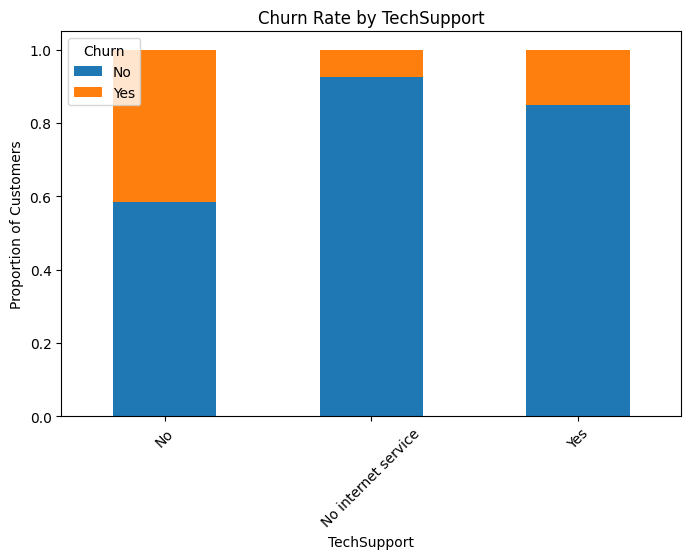

In [4]:
# Stacked bar charts for categorical features vs. Churn
def plot_stacked_bar(column):
    churn_crosstab = pd.crosstab(df[column], df['Churn'])
    churn_crosstab_norm = churn_crosstab.div(churn_crosstab.sum(axis=1), axis=0)
    churn_crosstab_norm.plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f'Churn Rate by {column}')
    plt.ylabel('Proportion of Customers')
    plt.xticks(rotation=45)
    plt.show()

plot_stacked_bar('Contract')
plot_stacked_bar('InternetService')
plot_stacked_bar('TechSupport')

These visualizations confirm that customers on month-to-month contracts, those with fiber optic internet, and those without tech support have visibly higher churn rates. 


In [ ]:
silver_path = r"C:\Users\mrakkuma\Documents\vamsi\Assignment\customer_churn_pipeline\data\silver"
os.makedirs(silver_path, exist_ok=True)

# Ensure TotalCharges is numeric for Parquet export
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0.0, inplace=True)

# Ensure satisfaction_score is numeric for Parquet export
df['satisfaction_score'] = pd.to_numeric(df['satisfaction_score'], errors='coerce')
df['satisfaction_score'].fillna(3, inplace=True)  # Assume neutral satisfaction

# Ensure last_interaction_days_ago is numeric for Parquet export
df['last_interaction_days_ago'] = pd.to_numeric(df['last_interaction_days_ago'], errors='coerce')
df['last_interaction_days_ago'].fillna(999, inplace=True)  # Assume very long time/no interaction

df.to_parquet(os.path.join(silver_path, "cleaned_churn_data.parquet"), index=False)



customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn
support_calls
satisfaction_score
last_interaction_days_ago


C:\Users\mrakkuma\AppData\Local\Temp\ipykernel_48384\3040207560.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0.0, inplace=True)
C:\Users\mrakkuma\AppData\Local\Temp\ipykernel_48384\3040207560.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 